In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import tensorflow as tf


# Custom Stuff with tf 

Following [this](https://www.tensorflow.org/tutorials/customization/basics) tutorial.  



## Tensors and Operations 

### Tensors 
+ ndarray similar to np arrays 
+ have a dtype and shape  
+ can resides in acellerator memory (like GPU)  
+ operations exist that consume and produce tensors (tf.add, tf.matmul, etc.) 


In [16]:
print(tf.add(1, 2))
print(tf.add([1, 2], [4, 3]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([5 5], shape=(2,), dtype=int32)


Differences between np arrays and tf arrays 
+ backed by accelerator memory (GPU, TPU) 
+ immutable 

In [36]:
t = tf.convert_to_tensor([1, 3])
try: 
    t[1] = 2
    print(t)
except:
    print('Assignment cant happen')

Assignment cant happen


### Datasets 

The dataset API builds pipelines for feeding data to your model.  It is used to build performant, complex input pipelines from simple, re-usable pieces that will feed your model's training or evaluation loops.  


#### Creating a source dataset 

`Dataset.from_tensors` , `Dataset.from_tensor_slices`, `TextLineDataset`, `TFRecordDataset`.  
See [dataset guide](https://www.tensorflow.org/guide/datasets#reading_input_data) for more info 

In [49]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6, 7, 8, 9])

import tempfile 

_, filename = tempfile.mkstemp()

with open(filename, 'w') as f: 
    f.write("""Line 1 
    Line 2
    Line 3""")
    
ds_file = tf.data.TextLineDataset(filename)

#### Apply transformations 

Use `map`, `batch`, `shuffle` to apply transforms 

In [50]:
ds_tensors = ds_tensors.map(tf.square).shuffle(3).batch(3)

ds_file = ds_file.batch(2) 

#### Iterate 

In [52]:
print("Elements of ds_tensors: ")
for x in ds_tensors: 
    print(x)

print("\n\nElements of ds_file")
for x in ds_file: 
    print(x)

Elements of ds_tensors: 
tf.Tensor([ 4 16  1], shape=(3,), dtype=int32)
tf.Tensor([ 9 36 25], shape=(3,), dtype=int32)
tf.Tensor([64 49 81], shape=(3,), dtype=int32)


Elements of ds_file
tf.Tensor([b'Line 1 ' b'    Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'    Line 3'], shape=(1,), dtype=string)


## Custom layers 

### Basics about layers 

ML models are expressible as the composition and stacking of relatively simple layers, and tf provides both a set of many common flayers as well as easy ways for you to write your own application-specific layers from scratch or as the composition of existing layers.  




In [6]:
import tensorflow as tf 

layer = tf.keras.layers.Dense(100) 

# Specifying the input shape is not required, 
#   but it is helpful for bookkeeping  
#   None is okay because the first dim is often batch size 
layer = tf.keras.layers.Dense(10, input_shape=(None, 5)) 

The full list of pre-existing layers can be found in the [tf documentaiton](https://www.tensorflow.org/api_docs/python/tf/keras/layers).  

To use a layer, call it like a function.  

In [9]:
rand_input = tf.random.uniform(shape=(3, 5))
layer(rand_input)

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[ 0.19751541, -0.7054427 ,  0.1310861 ,  0.06377794, -0.39124075,
         0.21372555, -0.13490479, -1.1408858 ,  0.6495783 ,  0.24658562],
       [-0.22508642, -0.38550738, -0.3078668 , -0.15155661, -0.22268218,
         0.28854308, -0.03095391, -0.5763471 ,  0.01185246, -0.057073  ],
       [-0.12592502, -0.40677354, -0.10757253, -0.00323736, -0.21257432,
         0.29044816, -0.06279465, -0.927053  ,  0.49395704, -0.27830514]],
      dtype=float32)>

View the layer's internal weights with: 
+ `.variables` 
+ `.kernel`
+ `.bias`
+ `.get_weights()`

In [15]:
print("The weights: ", layer.get_weights()[0])
print("\n\nThe bias vector: ", layer.get_weights()[1])

The weights:  [[-0.6151457  -0.37732014 -0.36944306 -0.07923156 -0.06382227  0.54897386
   0.28158545 -0.41779557 -0.32737064 -0.03373742]
 [ 0.40742654  0.06895435 -0.08180958 -0.11154413 -0.2934218  -0.08933067
  -0.30466813 -0.528558    0.04949534 -0.40269253]
 [ 0.4454506  -0.3880657  -0.25994587 -0.40932828 -0.4102828  -0.4038393
  -0.6317298  -0.16619813  0.43802637  0.40047497]
 [-0.4091817  -0.40072578  0.33082432  0.3862627   0.13596869  0.51842386
   0.56901294 -0.34254694 -0.01703238  0.4178304 ]
 [ 0.02109462  0.27399957  0.4948818   0.4104212   0.30240148 -0.00092238
   0.19588804 -0.08725476  0.5730093  -0.40063772]]


The bias vector:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Implementing custom layers

Extend the tf.keras.Layer class and implement 

+ `__init__`
    + input independent initalization (you may not know the size of the input)
+ `build`
    + You know the shape of the input tensors, do the rest of the initialization 
+ `call`
    + do a forward pass through the layer  



In [21]:
class MyDenseLayer(tf.keras.layers.Layer): 
    """ A custom layer that mimicks the Dense layer 
    """
    
    def __init__(self, num_outputs): 
        super(MyDenseLayer, self).__init__()
        self.num_outputs = num_outputs 
        
    def build(self, input_shape): 
        self.kernel = self.add_weight("kernel", 
                                      shape=[int(input_shape[-1]), 
                                             self.num_outputs])
        
    def call(self, inp): 
        return tf.matmul(inp, self.kernel)
    
    
layer = MyDenseLayer(10)

In [22]:
layer(rand_input)

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[ 0.00946729,  0.8943903 , -0.6085113 ,  0.29448614, -0.47020212,
        -0.79076886, -0.5753122 ,  0.49670878,  0.62063354,  0.371116  ],
       [ 0.10515275, -0.1998961 , -0.1443118 ,  0.22477469,  0.00891055,
        -0.5150931 , -0.4341933 ,  0.6582951 ,  0.36257097,  0.31927735],
       [ 0.14457753,  0.17884803, -0.44523716,  0.7383916 , -0.42655924,
        -0.6318537 , -0.44939354,  0.88576764,  0.7464748 ,  0.77396894]],
      dtype=float32)>

In [23]:
print([var.name for var in layer.trainable_variables])

['my_dense_layer/kernel:0']


### Composing layers 

E.g. Residual block in a resnet is a composition of convolutions, batch norms, and shortcut.  Layers can be nested inside other layers.  

Typically, you inherit from keras.Model when you need the model methods like: fit, evaluate, and save.  

keras.Model also allows you to track internal layers in addition to tracking variables.  

In [24]:
# skipping code for residual block...it basically inherits from 
#  keras.Model and defines a __init__() and call()

Much of the time, layers will be called sequentially.  Thus, `tf.keras.Sequential()`.  

In [25]:
my_seq = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (1, 1),
                           input_shape=(None, None, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(2, 1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(3, (1, 1)),
    tf.keras.layers.BatchNormalization()
])


my_seq(tf.zeros([1, 2, 3, 3]))

<tf.Tensor: shape=(1, 2, 3, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)>

## Custom Training 

Reviewing some foundational stuff before explaining how to design custom training... 

### Variables 

Tensors are immutable stateless objects.  `x + 2` does not mutate the state of x.  You need to do `x = x + 2`.  You cannot do `x[2] = 2`

A `tf.Variable` object stores a value and implicitly reads from this stored value.  There are operations that manipulate the value stored in a tf variable.  

In [5]:
v = tf.Variable(1.0)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>


In [8]:
v.assign(3.0)
v

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>

In [12]:
v + 1
v # remained unchanged 

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>

In [13]:
v.assign(tf.square(v))
print(v.numpy())

9.0


Computations using `tf.Variable` are automatically traced when computing gradients.  For variables that represent embeddings, Tensorflow will do sparse updates by default, which are more computation and memory efficient.  

### Example using linear model

1. Define model 
2. Define loss function 
3. Prepare training data 
4. Run through the training data and use an optimizer to adjust the variables to fit the data 

We'll make a simple linear model here:  `f(x) = x*W + b`.  W=3, b=2.  


#### Define model 


In [27]:
class Model(object): 
    
    def __init__(self): 
        # init W to 5 and b to 0.  
        #  Should actually be random numbers 
        self.W = tf.Variable(5.0) 
        self.b = tf.Variable(0.0)
        
    def __call__(self, x): 
        return self.W * x + self.b
    
    
model = Model()

assert model(3.0).numpy() == 15.0

#### Define loss function 

A loss function measures how well the output of a model for a given input matches the target output.  The goal is to minimize this difference during training.  Lets use the standard L2 loss (Ridge regression)  


In [28]:
def loss(y_true, y_pred): 
    """L2 loss.   mean { (y_true - y_pred) ^2 }  
    """
    return tf.reduce_mean(tf.square(y_true - y_pred))

#### Prepare training data 

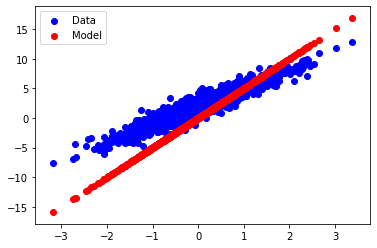

Current loss: 8.935750


In [34]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.legend(['Data', 'Model'])
plt.show()
print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())


#### Define training loop 

Use tf.GradientTape for automatic differentiation and tf.assign_sub for decrementing a value (combines tf.assign and tf.sub).  

In [35]:
def train(model, inputs, outputs, learning_rate): 
    
    # forward pass
    with tf.GradientTape() as t: 
        current_loss = loss(outputs, model(inputs))
        
    # Compute gradients 
    dW, db = t.gradient(current_loss, [model.W, model.b])
    
    # Adjust weights 
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

Tie it all together 

Epoch  0: W=5.00 b=0.00, loss=8.93575
Epoch  1: W=4.61 b=0.41, loss=6.07997
Epoch  2: W=4.30 b=0.73, loss=4.24666
Epoch  3: W=4.05 b=0.99, loss=3.06958
Epoch  4: W=3.85 b=1.20, loss=2.31374
Epoch  5: W=3.68 b=1.37, loss=1.82832
Epoch  6: W=3.55 b=1.50, loss=1.51653
Epoch  7: W=3.44 b=1.60, loss=1.31623
Epoch  8: W=3.36 b=1.69, loss=1.18754
Epoch  9: W=3.29 b=1.75, loss=1.10485


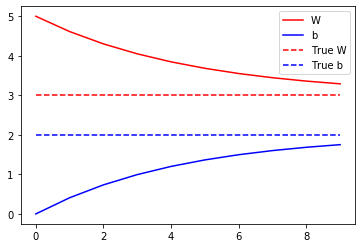

In [36]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)


for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(outputs, model(inputs))

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


## Custom training walkthrough 